## A continuous formulation for the Maximum s-defective Clique Problem in k-graphs

Let $G := (V, E)$ be a $k$-graph with vertices $V$ and edges $E$. Let $0 < \alpha \leq \frac{1}{k(k - 1)}$ (with strict inequality for $k = 2$) and $\beta > 0$ and consider the following problem :
\begin{equation}
    \max_{\text{s.t. } (x,y) \in \mathcal{P}_s} \sum_{e \in \overline{E}} y_e \prod_{i \in e} x_i - \sum_{e \in \overline{E}} \prod_{i \in e} x_i - \alpha \|x\|_k^k + \beta \|y\|_2^2
\end{equation}

In the following, we will denote $\tilde{h}$ the objective of the above problem. We claim that maximizers of this problem are attained at $p = (x^{(C)}, y^{(p)})$, where $s \geq l = \textbf{1}^Ty^{(p)} \in \mathbb{N}$, with $C$ an $l$-defective clique in $G$ which is also a maximal clique in $G\cup G(y^{(p)})$, and $y^{(p)} \in \{0, 1\}^{\overline{E}}$ such that $y_e^{(p)} = 1$ for every $e \in \binom{C}{k}\cap \overline{E}$ and with $\text{supp}(y^{(p)})$ of maximum cardinality under these constraints, and conversely we also claim that every maximal $s$-defective clique in $G$ is associated to such a minimizer.


# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
import scipy as sp
import scipy.optimize
from itertools import permutations, combinations, product
from IPython.display import clear_output
import requests
import time
import json

COLAB = True

# Functions on vertices and hypergraphs

In [2]:
def generate_random_adjacency_tensor(k, n, prob):
    """
    Generate a random binary adjacency tensor for a hypergraph.

    Parameters:
    k (int): The rank of the hypergraph (number of vertices in each edge).
    n (int): The number of vertices.
    prob (float): The probability for each edge to be part of the graph.

    Returns:
    ndarray: A random binary adjacency tensor of shape (n, n, ..., n).
    """
    # Create a tensor filled with zeros
    adjacency_tensor = np.zeros((n,) * k, dtype=int)

    # Generate random unique edges
    for idx in list(combinations(np.arange(n), k)):
        # Assign an edge with probability prob
        if np.random.rand() < prob :
            permuted_indices = list(permutations(idx))

            # Set values to 1 at indices that are permutations
            for idx in permuted_indices:
                adjacency_tensor[idx] = 1

    return adjacency_tensor

In [3]:
def complementary_hypergraph(adjacency_tensor):
    """
    Compute the adjacency tensor of the complementary hypergraph.

    Parameters:
    adjacency_tensor (ndarray): The adjacency tensor of the original hypergraph.

    Returns:
    ndarray: The adjacency tensor of the complementary hypergraph.
    """
    # Initialize with zeros
    complementary_adjacency_tensor = np.zeros(adjacency_tensor.shape)

    # Reverse the values
    for idx in list(product(*[range(dim) for dim in adjacency_tensor.shape])):
        if len(set(idx)) == k:
            # If all indices are different (representing an edge), flip 0s to 1s and vice versa
            complementary_adjacency_tensor[idx] = 1 - adjacency_tensor[idx]
        else:
            complementary_adjacency_tensor[idx] = 0

    return complementary_adjacency_tensor

In [4]:
def plot_hypergraph(adjacency_tensor, vertices_positions):
    """
    Plot a hypergraph using an adjacency tensor and vertices positions.

    Parameters:
    adjacency_tensor (ndarray): The binary adjacency tensor.
    vertices_positions (ndarray): The positions of vertices on a plane, size (2, n).

    Returns:
    None
    """
    n = vertices_positions.shape[1]

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Find the edges to plot
    edges = []

    for idx in np.ndindex(*adjacency_tensor.shape):
        if adjacency_tensor[idx] == 1:
            edges.append(tuple(sorted(idx)))

    # Plot edges as transparent polygons
    for edge_idx in set(edges) :
        edge_points = vertices_positions[:, edge_idx]
        edge_polygon = mpatches.Polygon(edge_points.T, closed=True, fill=True, edgecolor='b', alpha=0.2)
        ax.add_patch(edge_polygon)

    # Plot vertices as points
    ax.scatter(vertices_positions[0,:], vertices_positions[1,:])

    # Set axis limits and labels
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    # Show the plot
    plt.show()

In [5]:
def is_s_defective_clique(adjacency_tensor, x, s):
    """
    Check if the support of vector x forms an s-defective k-clique in a hypergraph.

    Parameters:
    adjacency_tensor (ndarray): The adjacency tensor of the hypergraph.
    x (ndarray): The vector representing chosen vertices.
    s (int): The maximum number of missing edges.

    Returns:
    bool: True if the support of x forms an s-defective k-clique, False otherwise.
    """
    k = len(adjacency_tensor.shape)

    # Find the support indices (indices where x is non-zero)
    support_indices = np.where(x != 0)[0]

    # Check if there are at least k vertices in the support
    if len(support_indices) < k:
        return False

    # Generate all combinations of k vertices from the support
    combinations_support = list(combinations(support_indices, k))

    # Check if there are less than s missing edges
    missing_edges = 0

    for subset in combinations_support:
        # Create a tuple of indices to access the hypergraph
        indices = tuple(subset)
        if adjacency_tensor[indices] != 1:
            missing_edges += 1

            #Skip useless computations
            if missing_edges > s:
                return False

    # Get to this point only if the number of missing edges is less than or equal to s
    return True

In [6]:
def plot_fake_edges_and_final_clique(adjacency_tensor, vertex_positions, x, y, subplot=None):
    """
    Plot the fake edges in the hypergraph and the final clique using an adjacency tensor and vertices positions.

    Parameters:
    adjacency_tensor (ndarray): The binary adjacency tensor.
    vertex_positions (ndarray): The positions of vertices on a plane, size (2, n).
    x (ndarray): The vector x coding for the final clique.
    y (ndarray): The multidimensional array y representing the fake edges.
    subplot (matplotlib.axes._subplots.AxesSubplot) : The subplot to work with, if set to None then a new one is created.

    Returns:
    None
    """
    n = vertex_positions.shape[1]

    # Create a figure and axis
    if subplot == None:
      fig, ax = plt.subplots()
    else:
      fig, ax = subplot

    # Find the edges to plot
    edges_original_graph = []
    fake_edges = []

    for idx in np.ndindex(*adjacency_tensor.shape):
        if adjacency_tensor[idx] == 1 and all(x[i] != 0 for i in idx): # Check if all x_i are non-zero
            edges_original_graph.append(tuple(sorted(idx)))
        elif y[idx] != 0:  # Check if the edge is coded in y
            fake_edges.append(tuple(sorted(idx)))

    # Plot edges as transparent polygons
    for edge_idx in set(edges_original_graph) :
        edge_points = vertex_positions[:, edge_idx]
        edge_polygon = mpatches.Polygon(edge_points.T, closed=True, fill=True, edgecolor='b', facecolor='b',alpha=0.2)
        ax.add_patch(edge_polygon)

    for edge_idx in set(fake_edges) :
        edge_points = vertex_positions[:, edge_idx]
        edge_polygon = mpatches.Polygon(edge_points.T, closed=True, fill=True, edgecolor='r', facecolor='r',alpha=0.2*y[edge_idx])
        ax.add_patch(edge_polygon)

    # Plot vertices as points
    ax.scatter(vertex_positions[0, :], vertex_positions[1, :], edgecolors='b', alpha = 0.2*(1 - x/np.max(x))) #Unchosen vertices
    ax.scatter(vertex_positions[0, :], vertex_positions[1, :], edgecolors='g', facecolors='y', alpha = 1*x/np.max(x)) #Chosen vertices

    # Add a legend
    handles, labels = ax.get_legend_handles_labels()

    green_dot = Line2D([0], [0], marker='o', markeredgecolor='b', linestyle='', alpha=0.2, label='Unchosen vertices')
    orange_dot = Line2D([0], [0], marker='o', markeredgecolor='g', markerfacecolor='y', linestyle='', alpha=1, label='Vertices of the clique')

    blue_patch = mpatches.Patch(color='b', label='Edges of the original graph')
    red_patch = mpatches.Patch(color='r', label='Fake edges')

    handles = [green_dot, orange_dot, blue_patch, red_patch]

    ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5))

    # Show the plot
    plt.show()

# DIMACS dataset

Download 2-graphs from the [DIMACS dataset](https://iridia.ulb.ac.be/~fmascia/maximum_clique/DIMACS-benchmark), convert them to k-graphs and initialize a dictionary containing the best known cliques sizes.

Available graphs are :
- C125.9
- C250.9
- C500.9
- C1000.9
- DSJC1000_5
- DSJC500_5
- MANN_a27
- MANN_a45
- brock200_2
- brock200_4
- brock400_2
- brock400_4
- brock800_2
- brock800_4
- gen200_p0.9_44
- gen200_p0.9_55
- gen400_p0.9_55
- gen400_p0.9_65
- gen400_p0.9_75
- hamming10-4
- hamming8-4
- keller4
- keller5
- p_hat300-1
- p_hat300-2
- p_hat300-3
- p_hat700-1
- p_hat700-2
- p_hat700-3
- p_hat1500-1
- p_hat1500-2
- p_hat1500-3


In [7]:
# Initialize a dictionary containing the best known cliques sizes on each graph
best_known_cliques_sizes = {
    "C125.9": 34,
    "C250.9": 44,
    "C500.9": 57,
    "C1000.9": 68,
    "C2000.9": 80,
    "DSJC1000_5": 15,
    "DSJC500_5": 13,
    "C2000.5": 16,
    "C4000.5": 18,
    "MANN_a27": 126,
    "MANN_a45": 345,
    "MANN_a81": 1100,
    "brock200_2": 12,
    "brock200_4": 17,
    "brock400_2": 29,
    "brock400_4": 33,
    "brock800_2": 24,
    "brock800_4": 26,
    "gen200_p0.9_44": 44,
    "gen200_p0.9_55": 55,
    "gen400_p0.9_55": 55,
    "gen400_p0.9_65": 65,
    "gen400_p0.9_75": 75,
    "hamming10-4": 40,
    "hamming8-4": 16,
    "keller4": 11,
    "keller5": 27,
    "keller6": 59,
    "p_hat300-1": 8,
    "p_hat300-2": 25,
    "p_hat300-3": 36,
    "p_hat700-1": 11,
    "p_hat700-2": 44,
    "p_hat700-3": 62,
    "p_hat1500-1": 12,
    "p_hat1500-2": 65,
    "p_hat1500-3": 94
}

In [8]:
def read_DIMACS_graph(graph_str):
    """
    Read a DIMACS formatted graph string and generate its adjacency matrix as an ndarray.

    Parameters:
    graph_str (str): The DIMACS formatted graph string.

    Returns:
    ndarray: The adjacency matrix of the graph.
    """
    lines = graph_str.split('\n')

    # Initialize variables to store graph information
    num_vertices = None
    num_edges = None
    edges = []

    # Parse the graph data
    for line in lines:
        parts = line.split()
        if len(parts) == 0:
            continue
        if parts[0] == 'p':
            num_vertices = int(parts[2])
            num_edges = int(parts[3])
        elif parts[0] == 'e':
            vertex1 = int(parts[1]) - 1  # Adjust indices to start from 0
            vertex2 = int(parts[2]) - 1
            edges.append((vertex1, vertex2))

    # Create an empty adjacency matrix
    adjacency_matrix = np.zeros((num_vertices, num_vertices), dtype=int)

    # Fill the adjacency matrix based on the edges
    for edge in edges:
        adjacency_matrix[edge[0], edge[1]] = 1
        adjacency_matrix[edge[1], edge[0]] = 1

    return adjacency_matrix

In [9]:
def adjacency_matrix_to_adjacency_tensor(adjacency_matrix, k):
    """
    Convert an adjacency matrix into a symmetric adjacency tensor for k-graphs.

    Parameters:
    adjacency_matrix (ndarray): The adjacency matrix of the graph.
    k (int): The order of the k-graph.

    Returns:
    ndarray: The symmetric adjacency tensor for k-graphs.
    """
    if k > 2:
        n = adjacency_matrix.shape[0]  # Number of vertices
        adjacency_tensor = np.zeros((n,) * k, dtype=int)

        # Iterate through all possible combinations of k vertices
        for indices in combinations(range(n), k):
            # Check if there is an edge between all pairs of vertices in the combination
            if all(adjacency_matrix[i, j] == 1 for i, j in combinations(indices, 2)):
                # Set the corresponding entries in the adjacency tensor to 1
                for perm in permutations(indices):
                    adjacency_tensor[perm] = 1
    else:
        return adjacency_matrix

    return adjacency_tensor

In [10]:
def download_and_convert_DIMACS_graphs(graph_names, k):
    """
    Download DIMACS formatted graph files, convert them into k-graph tensors, and store them in a dictionary.

    Parameters:
    graph_names (list): A list of strings representing the names of the desired graphs.
    k (int): The order of the k-graph to generate.

    Returns:
    dict: A dictionary where keys are graph names, and values are the k-graph tensors.
    """
    graph_data = {}

    base_url = "http://iridia.ulb.ac.be/~fmascia/files/DIMACS/"

    for graph_name in graph_names:
        url = base_url + graph_name + ".clq"

        try:
            response = requests.get(url)
            if response.status_code == 200:
                # Parse the DIMACS file and store the adjacency matrix
                adjacency_matrix = read_DIMACS_graph(response.text)

                # Generate the associated k-graph tensor
                k_graph_tensor = adjacency_matrix_to_adjacency_tensor(adjacency_matrix, k)

                graph_data[graph_name] = k_graph_tensor
            else:
                print(f"Failed to download {graph_name}.clq")
        except Exception as e:
            print(f"Error downloading {graph_name}.clq: {str(e)}")

    return graph_data

# Miscellaneous functions

In [11]:
def s_max_indices(arr, s):
    """
    Get the indices of the s maximal positive values of a symmetrical tensor, ignoring NaN and negative values and considering only the indices corresponding to edges.
    Parameters:
    arr (ndarray): The input multidimensional array.
    s (int): The number of maximal indices to return.

    Returns:
    tuple: The indices of the s maximal values.
    """
    # Dimensions
    k = len(arr.shape)  # Order of the tensor
    n = arr.shape[0]  # Length of each dimension

    # Arrays storing the s largest found values, their indices and the position of the minimum between them
    max_values = np.full(s, np.NINF)
    max_values_indices = np.zeros((s, k), dtype=int)
    idx_min_of_max_values = 0

    for idx in combinations(np.arange(n), k):
        value = arr[idx]
        if value > 0 and value > max_values[idx_min_of_max_values]: # In the first check, if value = np.nan it also returns False
            max_values[idx_min_of_max_values] = value
            max_values_indices[idx_min_of_max_values, :] = idx
            idx_min_of_max_values = np.argmin(max_values)

    # In case there are fewer than s values that are positive and not NaN
    valid_indices = max_values_indices[max_values != np.NINF]

    # If there is such a value
    if len(valid_indices) > 0:
        return tuple(valid_indices.T)
    else:
        return [] # Doing array[()] returns the whole array and not just an empty one

In [12]:
def s_minimal_indices_in_support(arr1, arr2, s):
    """
    Get the indices of the s minimal negative values of arr1 that are in the support of arr2 and considering only the indices corresponding to edges.

    Parameters:
    arr1 (ndarray): The first input multidimensional array.
    arr2 (ndarray): The second input multidimensional array serving as a mask.
    s (int): The number of minimal indices to return.

    Returns:
    list: A list of tuples, each containing the indices of the s minimal values in arr1 based on the mask provided by arr2.
    """
    # Dimensions
    k = len(arr1.shape)  # Order of the tensor
    n = arr1.shape[0]  # Length of each dimension

    # Arrays storing the s largest found values, their indices and the position of the minimum between them
    min_values = np.full(s, np.inf)
    min_values_indices = np.zeros((s, k), dtype=int)
    idx_max_of_min_values = 0

    for idx in combinations(np.arange(n), k):
        value = arr1[idx]
        mask = arr2[idx]

        if not np.isnan(value) and mask != 0 and value < min_values[idx_max_of_min_values]:
            min_values[idx_max_of_min_values] = value
            min_values_indices[idx_max_of_min_values, :] = idx
            idx_max_of_min_values = np.argmax(min_values)

    # In case there are fewer than s values that are positive and not NaN
    valid_indices = min_values_indices[min_values != np.inf]

    # If there is such a value
    if len(valid_indices) > 0:
        return tuple(valid_indices.T)
    else:
        return [] # Doing array[()] returns the whole array and not just an empty one

# Objective function and derivatives (novel formulation)

Denoting the graph $G = (V, E)$, our objective function is :
\begin{align}
  \tilde{h}(x, y) := -h(x,y) :&= \sum_{e\in \overline{E}}y_e\prod_{i\in e}x_i - \sum_{e\in \overline{E}}\prod_{i\in e}x_i - \alpha \|x\|_k^k + \beta \|y\|_2^2 \\
  &= \frac{1}{k!}(\mathcal{A}(y) - \mathcal{A})x^k - \alpha \|x\|_k^k + \beta \|y\|_2^2
\end{align}

where $\mathcal{A}$ is the adjacency tensor of the graph and $\mathcal{A}(y)$ is the adjacency tensor made of the fake edges.

In [13]:
def objective_function(Abar, x, y, k, k_factorial, alpha, beta):
    """
    Compute the objective function value using provided tensors and parameters.

    Parameters:
    Abar (ndarray): The adjacency tensor of the complementary of the graph of shape (n, n, ..., n).
    x (ndarray): The vector x of length n.
    y (ndarray): The multidimensional array y of shape (n, n, ..., n).
    k (int): The number of iterations for tensor contraction.
    k_factorial (int): The preprocessed value of k!.
    alpha (float): The parameter alpha.
    beta (float): The parameter beta.

    Returns:
    float: The computed objective function value.
    """
    # Compute (A(y) - Abar)x^k
    Ayxk = y - Abar
    for _ in range(k):
        Ayxk = np.tensordot(Ayxk, x, axes=1)

    # Compute \|x\|_k^k
    norm_xk = np.sum(x ** k)

    # Compute \|y\|_2^2
    norm_y2 = np.sum(y ** 2)

    # Compute the final result
    return Ayxk / k_factorial - alpha * norm_xk + beta * norm_y2

The gradient with respect to $x$ is
\begin{align}
  \nabla_x \tilde{h}(x, y) &= \frac{k}{k!}(\mathcal{A}(y) - \mathcal{A})x^{k-1} - k\alpha x^{[k-1]}
\end{align}

In [14]:
def objective_function_gradient_x(Abar, x, y, k, k_factorial, alpha):
    """
    Compute the gradient of the objective function with respect to x.

    Parameters:
    Abar (ndarray): The adjacency tensor of the complementary of the graph of shape (n, n, ..., n).
    x (ndarray): The vector x of length n.
    y (ndarray): The multidimensional array y of shape (n, n, ..., n).
    k (int): The rank of the hypergraph.
    k_factorial (int): The preprocessed value of k!.
    alpha (float): The parameter alpha.

    Returns:
    ndarray: The computed gradient of the objective function with respect to x.
    """
    # Compute (A(y) - Abar)x^{k-1}
    Ayxk_minus_1 = y - Abar

    for _ in range(k - 1):
        Ayxk_minus_1 = np.tensordot(Ayxk_minus_1, x, axes=1)

    # Compute the final derivative
    return Ayxk_minus_1 * k / k_factorial - k * alpha * x**(k - 1)

The derivative with respect to a component of $y$ is
\begin{align}
  \frac{\partial \tilde{h}}{\partial y_e} (x, y) &= \prod_{i \in e}x_i + 2\beta y_e
\end{align}

The full tensor $\left( \prod_{i \in e}x_i + 2\beta y_e \right)_e$ is computed to benefit from Numpy's fast implementation of the products (the products tensor is simply $k$ outers products of x), then the edges $e \in E$ are discarded by replacing their value in the gradient by NaN.

In [15]:
def objective_function_gradient_y(Abar, x, y, k_factorial, beta):
    """
    Compute the gradient of the objective function with respect to y.

    Parameters:
    Abar (ndarray): The adjacency tensor of the complementary of the graph of shape (n, n, ..., n).
    x (ndarray): The vector x of length n.
    y (ndarray): The multidimensional array y of shape (n, n, ..., n).
    k_factorial (int): The preprocessed value of k!.
    beta (float): The parameter beta.

    Returns:
    ndarray: The computed gradient of the objective function with respect to y.
    """
    # Compute the product of the x_i where i is in e
    gradient = x
    for _ in range(k - 1):
        gradient = np.tensordot(gradient, x, axes=0)

    gradient += 2 * beta * y  # Gradient of the regularization term
    gradient[Abar == 0] = np.nan  # The value of edges that do not belong to the complement of the graph are replaced by NaN to discard them

    return gradient

The above function computes the **full** gradient with lots of 0 that will not be used in the FW variants. In practice, in order to avoid computing these expensive but useless values, we only compute a subtensor of the gradient with the following function, which additionally provides an array mapping its indices to the corresponding indices in the full gradient.

In [16]:
def objective_function_reduced_gradient_y(Abar, x, y, k_factorial, beta):
    """
    Compute the reduced gradient of the objective function with respect to y.

    Parameters:
    Abar (ndarray): The adjacency tensor of the complementary graph of shape (n, n, ..., n).
    x (ndarray): The vector x of length n.
    y (ndarray): The multidimensional array y of shape (n, n, ..., n).
    k_factorial (int): Preprocessed value of k!.
    beta (float): Parameter beta.

    Returns:
    tuple: Computed reduced gradient of the objective function with respect to y
    and a list mapping its indices to the real ones.
    """
    # Find indices contributing to the value 2*beta*y
    non_zero_indices_y = np.where(y != 0)
    non_zero_indices_x = np.where(x != 0)[0]

    # Keep only the indices contributing to non-zero gradient values
    non_zero_indices_gradient_set = set(np.concatenate([*non_zero_indices_y, non_zero_indices_x]))
    non_zero_indices_gradient_list = np.sort(list(non_zero_indices_gradient_set))

    # Compute the reduced arguments
    k = len(y.shape)

    reduced_indices_y = np.ix_(*[non_zero_indices_gradient_list] * k)
    reduced_Abar = Abar[reduced_indices_y]
    y_reduced = y[reduced_indices_y]

    reduced_x = x[non_zero_indices_gradient_list]

    # Compute the reduced gradient for y
    return objective_function_gradient_y(reduced_Abar, reduced_x, y_reduced, k_factorial, beta), non_zero_indices_gradient_list

# Objective function and derivatives (previous formulation)

The following is an implementation of the continuous formulation of the MCP (designed for $k=2$) found in [this paper](https://arxiv.org/abs/2103.15907).

Denoting the graph $G = (V, E)$, the previous objective function is :
\begin{align}
  h(x, y) := x^T(A + A(y))x + \frac{\alpha}{2} \|x\|_2^2 + \frac{\beta}{2} \|y\|_2^2
\end{align}

where $A$ is the adjacency matrix of the graph and $A(y)$ is the adjacency matrix made of the fake edges.

In [17]:
def old_objective_function(A, x, y, alpha, beta):
    """
    Compute the objective function value using provided tensors and parameters.

    Parameters:
    A (ndarray): The adjacency matrix of the graph of shape (n, n).
    x (ndarray): The vector x of length n.
    y (ndarray): The multidimensional array y of shape (n, n).
    alpha (float): The parameter alpha.
    beta (float): The parameter beta.

    Returns:
    float: The computed objective function value.
    """
    # Compute \|x\|_2^2
    norm_x2 = np.sum(x ** 2)

    # Compute \|y\|_2^2
    norm_y2 = np.sum(y ** 2)

    # Compute the final result
    result = x @ ((A + y) @ x) + alpha / 2 * norm_x2 + beta / 2 * norm_y2
    return result

The gradient with respect to $x$ is
\begin{align}
  \nabla_x h(x, y) &= 2(A+A(y))x + \alpha x
\end{align}

In [18]:
def old_objective_function_gradient_x(A, x, y, alpha):
    """
    Compute the gradient of the objective function with respect to x.

    Parameters:
    A (ndarray): The adjacency matrix of the graph of shape (n, n).
    x (ndarray): The vector x of length n.
    y (ndarray): The multidimensional array y of shape (n, n).
    alpha (float): The parameter alpha.

    Returns:
    ndarray: The computed gradient of the objective function with respect to x.
    """
    gradient = 2 * (A + y) @ x + alpha * x
    return gradient

The derivative with respect to a component of $y$ is
\begin{align}
  \frac{\partial h}{\partial y_{ij}} (x, y) &= 2x_i x_j + \beta y_{ij}
\end{align}

In [19]:
def old_objective_function_gradient_y(Abar, x, y, beta):
    """
    Compute the gradient of the objective function with respect to y.

    Parameters:
    Abar (ndarray): The adjacency matrix of the complementary of the graph of shape (n, n).
    x (ndarray): The vector x of length n.
    y (ndarray): The multidimensional array y of shape (n, n).
    beta (float): The parameter beta.

    Returns:
    ndarray: The computed gradient of the objective function with respect to y.
    """
    # Compute x_i*x_j
    gradient = 2 * np.outer(x, x)

    gradient += beta * y  # Gradient of the regularization term
    gradient[Abar == 0] = np.nan  # The value of edges that do not belong to the complement of the graph are replaced by NaN to discard them

    return gradient

And its reduced version.

In [20]:
def old_objective_function_reduced_gradient_y(Abar, x, y, beta):
    """
    Compute the reduced gradient of the objective function with respect to y.

    Parameters:
    Abar (ndarray): The adjacency matrix of the complementary graph of shape (n, n).
    x (ndarray): The vector x of length n.
    y (ndarray): The multidimensional array y of shape (n, n).
    beta (float): Parameter beta.

    Returns:
    tuple: Computed reduced gradient of the objective function with respect to y
    and a list mapping its indices to the real ones.
    """
    # Find indices contributing to the value 2*beta*y
    non_zero_indices_y = np.where(y != 0)
    non_zero_indices_x = np.where(x != 0)[0]

    # Keep only the indices contributing to non-zero gradient values
    non_zero_indices_gradient_set = set(np.concatenate([*non_zero_indices_y, non_zero_indices_x]))
    non_zero_indices_gradient_list = np.sort(list(non_zero_indices_gradient_set))

    # Compute the reduced arguments
    reduced_indices_y = np.ix_(*[non_zero_indices_gradient_list] * 2)
    reduced_Abar = Abar[reduced_indices_y]
    y_reduced = y[reduced_indices_y]

    reduced_x = x[non_zero_indices_gradient_list]

    # Compute the reduced gradient for y
    return old_objective_function_gradient_y(reduced_Abar, reduced_x, y_reduced, beta), non_zero_indices_gradient_list

# Frank Wolfe variants

**Common parts**

In [21]:
def plot_iteration_progress(iteration, verbosity, subplot, A, vertex_positions, x, y, number_of_steps=None):
    """
    Plot the evolution of the x and y variables for a given iteration.

    Parameters:
    iteration (int): The current iteration number.
    verbosity (int): Verbosity of the function, 0 is none, 1 is only at the end, 2 is for each iteration and 3 plots a graph (default is 0).
    subplot: The subplot to update, used if verbosity is set to 3.
    A (ndarray): The adjacency tensor.
    vertex_positions (ndarray): The positions of vertices on a plane.
    x (array): The x variable coding for the chosen vertices.
    y (array): The y variable coding for the fake edges.
    """
    if verbosity == 3:
        subplot[1].clear()
        plot_fake_edges_and_final_clique(A, vertex_positions, x, y, subplot)
        subplot[1].set_title("Iteration %i" % iteration)

        if COLAB:
            clear_output(wait=True)  # For Google Colab
            display(subplot[0])  # For Google Colab

    if verbosity == 2:
        if number_of_steps==None:
            print("Iteration %i finished." % iteration)
        else:
            print("Iteration %i finished with %i small steps." % (iteration, number_of_steps))

**Parts of the FWdc**

**Initialization:**
- Initialize: $z_0 = (x_0, y_0) \in \Delta \times \mathcal{D}_s(G)$, $k = 0$

**Algorithm Steps:**
1. While $w_k$ is not stationary:
  
  a. Compute $x_{k+1}$ by applying one step of the previous algorithm with $w_0 = x_k$ and $f(w) = \tilde{h}(w, y_k)$.
  
  b. Let $y_{k+1} \in \text{arg max}_{y\in\mathcal{D}_s(G)} \nabla_y h_G(x_k,y_k)^Ty$.
  
  c. Set $k = k+1$.

2. STOP

In [22]:
def FDFW_only_x_direction_stepsize(x, gradient):
    """
    Compute the update direction and the maximum feasible step size for a step of the FDFW on x.

    Parameters:
    x (array): The current point.
    gradient (array): The gradient of the objective function at x.

    Returns:
    tuple: A tuple containing the update direction (array) and the maximum feasible step size (float).
    """
    # Find the indices of the components with the largest and smallest (only on the support of x) gradients
    max_grad_index = np.argmax(gradient)

    nonzero_indices = np.where(x != 0)[0]
    min_grad_index = nonzero_indices[np.argmin(gradient[nonzero_indices])]

    # Define the linear approximation direction
    direction = np.zeros(len(x))

    dot_grad_wk = np.dot(gradient, x)  # Corresponds to the dot product between the gradient and w_k in the algorithm

    dot_grad_dfw = gradient[max_grad_index] - dot_grad_wk
    dot_grad_dfd = dot_grad_wk - gradient[min_grad_index]

    if dot_grad_dfw > dot_grad_dfd:
        # d_FW direction
        direction[max_grad_index] = 1
        direction -= x
        step_size_max = 1
    else:
        # d_FD direction
        direction[min_grad_index] = -1
        direction += x
        step_size_max = np.min(
            [abs(x[min_grad_index] / direction[min_grad_index]) if direction[min_grad_index] != 0 else np.inf])  # To ensure that x stays above 0
                                                                       # There is no need to ensure that x stays below 1 as it is always the case

    return direction, step_size_max

def FWdc_update_y(reduced_gradient, map_indices, y_shape, s):
    """
    Update y for a step of the FWdc algorithm.

    Parameters:
    reduced_gradient (ndarray): The gradient of the objective function with respect to y, in its reduced version to keep only the relevant values.
    map_indices (list): List mapping the indices of the reduced gradient to the corresponding indices in the full gradient.
    y_shape (tuple): Shape of y.
    s (int): The number of fake edges to add.

    Returns:
    ndarray: The updated y.
    """
    # Get the indices of the s maximum values of the gradient
    reduced_greatest_indices = s_max_indices(reduced_gradient, s)
    greatest_indices = [
        [map_indices[reduced_idx] for reduced_idx in array_dim] for array_dim in reduced_greatest_indices
    ]

    # Define the new y
    y_new = np.zeros(y_shape)

    # Get all permutations of indices
    k = len(y_shape)

    if len(greatest_indices) > 0:
        greatest_indices_with_permutations = np.empty(shape=(k, 0), dtype=int)
        for perm in permutations(range(k)):
            greatest_indices_with_permutations = [np.concatenate(
                (greatest_indices_with_permutations[i], greatest_indices[perm[i]])) for i in range(k)]

        # Assign the fake edges
        y_new[tuple(greatest_indices_with_permutations)] = 1

    return y_new

In [23]:
def FDFW_only_x(obj_func, grad_func, A, x0, n, s, k_factorial, max_iter=100, tol=1e-3, verbosity=0,
                vertex_positions=None):
    """
    Perform the FDFW on the x component.

    Parameters:
    obj_func (function): The objective function to minimize.
    grad_func (function): The gradient function of the objective function with respect to x.
    A (ndarray): The adjacency tensor of shape (n, n, ..., n).
    x0 (ndarray): The starting point.
    n (int): The dimensionality of the problem.
    s (int): The maximum number of missing edges in the clique.
    k_factorial (int): The preprocessed value of k!.
    max_iter (int): The maximum number of iterations (default is 100).
    tol (float): The tolerance for convergence (default is 1e-3).
    verbosity (int): Verbosity of the function, 0 is none, 1 is only at the end, 2 is for each iteration and 3 plots a graph (default is 0).
    vertex_positions (ndarray): The positions of vertices on a plane, size (2, n), necessary if verbosity is set to 3.

    Returns:
    tuple: A tuple containing the optimized x and the runtime of the function.
    """
    # Initialization
    start_time = time.time()

    x = x0

    if verbosity == 3 and max_iter > 1:
        subplot = plt.subplots()
    else:
        subplot = None

    iteration = 0

    while iteration < max_iter:
        iteration += 1

        # Direction for x
        gradient = grad_func(x)
        direction, step_size_max = FDFW_only_x_direction_stepsize(x, gradient)

        # Perform Armijo line search to find the step size
        step_size = step_size_max
        while step_size > 1e-14 and obj_func(x + step_size * direction) < obj_func(x) + 0.1 * step_size * np.dot(
                gradient, direction):
            step_size *= 0.3

        # Update the current point
        x_new = x + step_size * direction

        # Some tricks to address numerical approximation errors
        x_new[x_new < 1e-15] = 0
        x_new /= np.sum(x_new)

        # Check for convergence
        if max_iter > 1:
            FW_gap = np.dot(gradient, x - x_new)

            x = x_new

            if is_s_defective_clique(A, x, s) and abs(FW_gap) < tol:
                break

            # Plot the progress
            plot_iteration_progress(iteration, verbosity, subplot, A, vertex_positions, x, np.zeros(A.shape))
        else:
            x = x_new

    # If used as a standalone function
    if max_iter > 1:
        end_time = time.time()
        elapsed_time = end_time - start_time

        if verbosity == 1 or verbosity == 2:
            print("FDFW on x finished in %f s with %i iterations."%(elapsed_time, iteration))

        return x, elapsed_time
    else:
        return x

def FWdc(obj_func, grad_func_x, reduced_grad_func_y, A, Abar, x0, y0, n, s, k_factorial, max_iter=100, tol=1e-3, verbosity=0,
         vertex_positions=None):
    """
    Perform the FWdc.

    Parameters:
    obj_func (function): The objective function to minimize.
    grad_func_x (function): The gradient function of the objective function with respect to x.
    reduced_grad_func_y (function): The gradient function of the objective function with respect to y, adjusted to compute only the relevant gradient values.
    A (ndarray): The adjacency tensor of shape (n, n, ..., n).
    Abar (ndarray): The complementary adjacency tensor of the same shape as A.
    x0 (ndarray): The starting point for x.
    y0 (ndarray): The starting point for y.
    n (int): The dimensionality of the problem.
    s (int): The maximum number of missing edges in the clique.
    k_factorial (int): The preprocessed value of k!.
    max_iter (int): The maximum number of iterations (default is 100).
    tol (float): The tolerance for convergence (default is 1e-3).
    verbosity (int): Verbosity of the function, 0 is none, 1 is only at the end, 2 is for each iteration and 3 plots a graph (default is 0).
    vertex_positions (ndarray): The positions of vertices on a plane, size (2, n), necessary if verbosity is set to 3.

    Returns:
    tuple: A tuple containing the optimized x and y and the runtime of the function.
    """
    # Initialization
    start_time = time.time()

    x = x0
    y = y0

    if verbosity == 3:
        subplot = plt.subplots()
    else:
        subplot = None

    iteration = 0

    while iteration < max_iter:
        iteration += 1

        # Update x
        x_new = FDFW_only_x(lambda t: obj_func(t, y), lambda t: grad_func_x(t, y), A, x, n, s, k_factorial, max_iter=1, tol=1e-3, verbosity=0, vertex_positions=None)

        # Update y
        reduced_gradient_y, map_indices = reduced_grad_func_y(x_new, y)
        y_new = FWdc_update_y(reduced_gradient_y, map_indices, y.shape, s)

        # Check for convergence : support of x is an s-defective clique, FW gap < tol
        FW_gap = np.dot(grad_func_x(x, y), x - x_new)

        x = x_new
        y = y_new

        if is_s_defective_clique(A, x, s) and abs(FW_gap) < tol:
            break

        # Plot the progress
        plot_iteration_progress(iteration, verbosity, subplot, A, vertex_positions, x, y)

    end_time = time.time()
    elapsed_time = end_time - start_time

    if verbosity == 1 or verbosity == 2:
        print("FWdc finished in %f s with %i iterations."%(elapsed_time, iteration))

    return x, y, elapsed_time

**Parts of the FDFW**

The algorithm is the following :

**Initialization:**  
- Initialize: $w_0 \in \mathcal{Q}$, $k = 0$

**Algorithm Steps:**  
1. While $w_k$ is not stationary:
   
   a. Let $s_k \in \text{arg max}_{y\in\mathcal{Q}} \nabla f(w_k)^Ty$ and $d_k^{\mathcal{F}\mathcal{W}} = s_k - w_k$.
   
   b. Let $v_k \in \text{arg min}_{y\in\mathcal{F}(w_k)} \nabla f(w_k)^Ty$ and $d_k^{\mathcal{F}\mathcal{D}} = w_k - v_k$.
   
   c. If $\nabla f(w_k)^Td_k^{\mathcal{F}\mathcal{W}} \geq \nabla f(w_k)^Td_k^{\mathcal{F}\mathcal{D}}$:
      - $d_k = d_k^{\mathcal{F}\mathcal{W}}$
   
   d. Else:
      - $d_k = d_k^{\mathcal{F}\mathcal{D}}$
   
   e. Choose the stepsize $\alpha_k \in (0, \alpha_k^{\max}]$ with a suitable criterion.
   
   f. Update $w_{k+1} = w_k + \alpha_k d_k$.
   
   g. Set $k = k+1$.

2. STOP

In [24]:
def FDFW_direction_stepsize(x, y, gradient_x, reduced_gradient_y, map_indices, k_factorial):
    """
    Compute the update direction and the maximum feasible step size for a step of the FDFW.

    Parameters:
    x (array): The current point for x.
    y (array): The current point for y.
    gradient_x (array): The gradient of the objective function with respect to x at the current point.
    reduced_gradient_y (array): The gradient of the objective function with respect to y at the current point, in its reduced version to keep only the relevant values.
    map_indices (list): List mapping the indices of the reduced gradient to the corresponding indices in the full gradient.
    k_factorial (int): The preprocessed value of k!.

    Returns:
    tuple: A tuple containing the update direction for x (array), the update direction for y (array), and the maximum feasible step size (float).
    """
    # Direction for x
    # Find the indices of the components with the largest and smallest (only on the support of x) gradients
    max_grad_index_x = np.argmax(gradient_x)

    nonzero_indices = np.where(x != 0)[0]
    min_grad_index_x = nonzero_indices[np.argmin(gradient_x[nonzero_indices])]

    # Direction for y
    reduced_indices_y = np.ix_(*[map_indices] * k)
    y_reduced = y[reduced_indices_y]

    reduced_greatest_indices = s_max_indices(reduced_gradient_y, s)
    greatest_indices = [
        [map_indices[reduced_idx] for reduced_idx in array_dim] for array_dim in reduced_greatest_indices
    ]

    y_equal_to_one_indices = np.where(y == 1)
    reduced_y_equal_to_one_indices = np.where(y_reduced == 1)

    support = y.copy()
    support[y_equal_to_one_indices] = 0  # To discard these values

    reduced_smallest_indices_in_support = s_minimal_indices_in_support(reduced_gradient_y, support[reduced_indices_y], s - len(y_equal_to_one_indices[0])//k_factorial)
    smallest_indices_in_support = [
        [map_indices[reduced_idx] for reduced_idx in array_dim] for array_dim in reduced_smallest_indices_in_support
    ]

    # Define the linear approximation direction for x and y
    direction_x = np.zeros(n)
    direction_y = np.zeros(y.shape)

    dot_grad_wk = np.dot(gradient_x, x) + np.nansum(np.multiply(reduced_gradient_y, y_reduced))/k_factorial  # Corresponds to the dot product between the gradient and w_k in the algorithm

    # greatest_indices and smallest_indices_in_support only contain s indices so no need to divide by k_factorial because there is no duplication
    dot_grad_dfw = gradient_x[max_grad_index_x] + np.sum(reduced_gradient_y[reduced_greatest_indices]) - dot_grad_wk
    dot_grad_dfd = dot_grad_wk - gradient_x[min_grad_index_x] - np.sum(reduced_gradient_y[reduced_smallest_indices_in_support]) - np.sum(reduced_gradient_y[reduced_y_equal_to_one_indices])/k_factorial

    if dot_grad_dfw > dot_grad_dfd:
        # d_FW direction for x
        direction_x[max_grad_index_x] = 1

        # Get all permutations of indices for y
        if len(greatest_indices) > 0:
            greatest_indices_with_permutations = np.empty(shape=(k, 0), dtype=int)
            for perm in permutations(range(k)):
                greatest_indices_with_permutations = [np.concatenate((greatest_indices_with_permutations[i], greatest_indices[perm[i]])) for i in range(k)]

            # Assign the fake edges for direction_y
            direction_y[tuple(greatest_indices_with_permutations)] = 1

        direction_x -= x
        direction_y -= y

        step_size_max = 1
    else:
        # d_FD direction for x
        direction_x[min_grad_index_x] = -1

        # Set direction for y equal to -1 where y equals one
        direction_y[y_equal_to_one_indices] = -1

        # Get all permutations of indices for y
        if len(smallest_indices_in_support) > 0:
            smallest_indices_with_permutations = np.empty(shape=(k, 0), dtype=int)
            for perm in permutations(range(k)):
                smallest_indices_with_permutations = [np.concatenate((smallest_indices_with_permutations[i], smallest_indices_in_support[perm[i]])) for i in range(k)]

            # Assign the fake edges for direction_y
            direction_y[tuple(smallest_indices_with_permutations)] = -1

        direction_x += x
        direction_y += y

        step_size_max_x_array = [abs(x[min_grad_index_x] / direction_x[min_grad_index_x]) if direction_x[min_grad_index_x] != 0 else np.inf] # To ensure that x stays above 0

        step_size_max_y_array = np.abs(y[direction_y < 0] / direction_y[direction_y < 0]).reshape(-1)  # To ensure that y stays above 0
                                                        # There is no need to ensure that x and y stay below 1 as it is always the case

        if np.sum(direction_y) > 1e-13:  # Not exactly zero due to numerical imprecisions
            step_size_max_y_array = np.concatenate((step_size_max_y_array, [(s*k_factorial - np.sum(y)) / np.sum(direction_y)]))  # To ensure that 1^T y stays below s

        step_size_max = np.min(np.concatenate((step_size_max_x_array, step_size_max_y_array)))

    return direction_x, direction_y, step_size_max

In [25]:
def FDFW(obj_func, grad_func_x, reduced_grad_func_y, A, Abar, x0, y0, n, s, k_factorial, max_iter=100, tol=1e-3, verbosity=0, vertex_positions=None):
    """
    Perform the FDFW on both components.

    Parameters:
    obj_func (function): The objective function to minimize.
    grad_func_x (function): The gradient function of the objective function with respect to x.
    reduced_grad_func_y (function): The gradient function of the objective function with respect to y, adjusted to compute only the relevant gradient values.
    A (ndarray): The adjacency tensor of shape (n, n, ..., n).
    Abar (ndarray): The complementary adjacency tensor of the same shape as A.
    x0 (ndarray): The starting point for x.
    y0 (ndarray): The starting point for y.
    n (int): The dimensionality of the problem.
    s (int): The maximum number of missing edges in the clique.
    k_factorial (int): The preprocessed value of k!.
    max_iter (int): The maximum number of iterations (default is 100).
    tol (float): The tolerance for convergence (default is 1e-3).
    verbosity (int): Verbosity of the function, 0 is none, 1 is only at the end, 2 is for each iteration and 3 plots a graph (default is 0).
    vertex_positions (ndarray): The positions of vertices on a plane, size (2, n), necessary if verbosity is set to 3.

    Returns:
    tuple: A tuple containing the optimized x and y and the runtime of the function.
    """
    # Initialization
    start_time = time.time()

    x = x0
    y = y0

    if verbosity == 3:
        subplot = plt.subplots()
    else:
        subplot = None

    iteration = 0

    while iteration < max_iter:
        iteration += 1

        # Direction for x and y
        gradient_x = grad_func_x(x, y)
        reduced_gradient_y, map_indices = reduced_grad_func_y(x, y)

        direction_x, direction_y, step_size_max = FDFW_direction_stepsize(x, y, gradient_x, reduced_gradient_y, map_indices, k_factorial)

        # Perform Armijo line search to find the step size
        reduced_indices_y = np.ix_(*[map_indices] * k)

        step_size = step_size_max
        while step_size > 1e-14 and obj_func(x + step_size * direction_x, y + step_size * direction_y) < obj_func(x, y) + 0.1 * step_size * (
                np.sum(np.multiply(gradient_x, direction_x)) + np.nansum(np.multiply(reduced_gradient_y, direction_y[reduced_indices_y]))):
            step_size *= 0.3

        # Update the current point
        x_new = x + step_size * direction_x
        y_new = y + step_size * direction_y

        # Some tricks to address numerical approximation errors
        x_new[x_new < 1e-15] = 0
        y_new[y_new < 1e-15] = 0
        y_new[y_new > 0.99] = 1

        x_new /= np.sum(x_new)

        sum_y = np.sum(y_new)
        if sum_y > s * k_factorial:
            y_new *= s * k_factorial / sum_y

        # Check for convergence: support of x is an s-defective clique, FW gap < tol
        FW_gap = np.dot(grad_func_x(x, y), x - x_new) + np.nansum(reduced_gradient_y*(y - y_new)[reduced_indices_y])/k_factorial

        x = x_new
        y = y_new

        if is_s_defective_clique(A, x, s) and abs(FW_gap) < tol:
            break

        # Plot the progress
        plot_iteration_progress(iteration, verbosity, subplot, A, vertex_positions, x, y)

    end_time = time.time()
    elapsed_time = end_time - start_time

    if verbosity == 1 or verbosity == 2:
        print("FDFW finished in %f s with %i iterations."%(elapsed_time, iteration))

    return x, y, elapsed_time

# Short Step Chain implementation

Implementation of the Short Step Chain procedure detailed in [Avoiding bad steps in Frank Wolfe variants](https://arxiv.org/abs/2012.12737), which is a gradient recycling procedure aiming at improving existing rates of convergence for the FW algorithm and its variants. Considering a Frank Wolfe variant, the SSC subroutine replaces the part dedicated to the steps, and allows to skip gradients update when performing small steps :

**Algorithm: FW container**

**Initialization:**
- Initialize: $x_0 \in \Omega$, $k = 0$

**Algorithm Steps:**

1. While $x_k$ is not stationary:
   - $g = \nabla f(x_k)$
   - $x_{k+1} = SSC(x_k, g)$
   - $k = k+1$

where SSC is the following algorithm :

**Algorithm: Short Step Chain Subroutine**

**Initialization:**
- Initialize: $y_0 = x$, $j = 0$

**Algorithm Steps:**

1. **Phase I:**
   - Select $d_j \in \mathcal{A}(y_j, g)$, $\alpha_{\max}^{(j)} \in \alpha_{\max}(y_j, d_j)$

   - If $d_j = 0$, return $y_j$

2. **Phase II:**
   - Compute $\beta_j$
   - Let $\alpha_j = \min(\alpha_{\max}^{(j)}, \beta_j)$
   - $y_{j+1} = y_j + \alpha_j d_j$

   - If $\alpha_j = \beta_j$, return $y_{j+1}$

3. $j = j+1$, repeat from the beginning of Phase I

**Implementation of the SSC for the FWdc**

Several parts of the naive implementation are reused, and the update for the $y$ component is put outside of the SSC procedure because the gradient is constant for its duration.

The two solutions for the polynomial equations are linked to the two balls in the computation of $\beta$, both of them having a real solution is equivalent to $y$ being in their intersection so no need to check it explicitely.

In [26]:
def FDFW_only_x_short_step_chain_subroutine(x, gradient, L, max_iter=100):
    """
    Perform the Short Step Chain phase of the FDFW on the x component.

    Parameters:
    x (array): The current point.
    gradient (array): The gradient of the objective function at x.
    L (float): The approximation of the Lipschitz constant.
    max_iter (int): The maximum number of iterations for Short Step Chain (default is 100).

    Returns:
    tuple: An array containing the updated point after the Short Step Chain phase and the number of small steps performed.
    """
    # Initialization
    y = x

    i = 0

    while i < max_iter:
        i += 1

        # Phase I
        direction, alpha_max = FDFW_only_x_direction_stepsize(y, gradient)

        if np.max(direction) == 0:
            return y, i

        # Phase II
        # First ball
        a1 = np.sum(direction**2)
        b1 = 2 * np.dot(direction, y - x - gradient / (2 * L))
        c1 = np.sum((y - x - gradient / (2 * L))**2) - np.sum(gradient**2) / (4 * L**2)

        # Second ball
        a2 = np.sum(direction**2)
        b2 = 2 * np.dot(direction, y - x)
        c2 = np.sum((y - x)**2) - (np.dot(gradient, direction) / L)**2

        # Compute beta
        if (b1**2 - 4*a1*c1 >= 0 and b2**2 - 4*a2*c2 >= 0): # If there are real solutions
            solution_1 = (-b1 + np.sqrt(b1**2 - 4 * a1 * c1)) / (2 * a1)
            solution_2 = (-b2 + np.sqrt(b2**2 - 4 * a2 * c2)) / (2 * a2)
            beta = min(solution_1, solution_2)
        else:
            beta = 0

        alpha = min(beta, alpha_max)
        y = y + alpha * direction

        if alpha == beta:
            return y, i

    # If the Short Step Chain chain did not converge within the maximum number of iterations
    return y, i

def FDFW_only_x_SSC(obj_func, grad_func, A, x0, L, n, s, k_factorial, max_iter=100, tol=1e-3, verbosity=0,
                vertex_positions=None):
    """
    Perform the FDFW on the x component, with the Short Step Chain procedure.

    Parameters:
    obj_func (function): The objective function to minimize.
    grad_func (function): The gradient function of the objective function with respect to x.
    A (ndarray): The adjacency tensor of shape (n, n, ..., n).
    x0 (ndarray): The starting point.
    L (float): The approximation of the Lipschitz constant.
    n (int): The dimensionality of the problem.
    s (int): The number of top indices to consider.
    k_factorial (int): The preprocessed value of k!.
    max_iter (int): The maximum number of iterations (default is 100).
    tol (float): The tolerance for convergence (default is 1e-3).
    verbosity (int): Verbosity of the function, 0 is none, 1 is only at the end, 2 is for each iteration and 3 plots a graph (default is 0).
    vertex_positions (ndarray): The positions of vertices on a plane, size (2, n), necessary if verbosity is set to 3.

    Returns:
    tuple: An array containing the optimized x, and if max_iter is set to 1 the number of small steps performed, otherwise the runtime of the function.
    """
    # Initialization
    start_time = time.time()

    x = x0

    if verbosity == 3:
        subplot = plt.subplots()
    else:
        subplot = None

    iteration = 0

    while iteration < max_iter:
        iteration += 1

        gradient = grad_func(x)
        x_new, n_steps = FDFW_only_x_short_step_chain_subroutine(x, gradient, L, max_iter=100)

        # Improve the Lipschitz constant approximation
        while obj_func(x) - obj_func(x_new) > 0.5 * np.dot(gradient, x - x_new):
            L *= 2.
            x_new, n_steps = FDFW_only_x_short_step_chain_subroutine(x, gradient, L, max_iter=100)

        # Some tricks to address numerical approximation errors
        x_new[x_new < 1e-15] = 0
        x_new /= np.sum(x_new)

        # Check for convergence
        if max_iter > 1:
            FW_gap = np.dot(gradient, x - x_new)

            x = x_new

            if is_s_defective_clique(A, x, s) and abs(FW_gap) < tol:
                break

            # Plot the progress
            plot_iteration_progress(iteration, verbosity, subplot, A, vertex_positions, x, np.zeros(A.shape), number_of_steps=n_steps)
        else:
            x = x_new

    # If used as a standalone function
    if max_iter > 1:
        end_time = time.time()
        elapsed_time = end_time - start_time

        if verbosity == 1 or verbosity == 2:
            print("FDFW on x finished in %f s with %i iterations."%(elapsed_time, iteration))

        return x, elapsed_time
    else:
        return x, L, n_steps

def FWdc_SSC(obj_func, grad_func_x, reduced_grad_func_y, A, Abar, x0, y0, L0, n, s, k_factorial, stop_updating_y_after=None, max_iter=100, tol=1e-3, verbosity=0,
              vertex_positions=None):
    """
    Perform the FWdc with the Short Step Chain procedure.

    Parameters:
    obj_func (function): The objective function to minimize.
    grad_func_x (function): The gradient function of the objective function with respect to x.
    reduced_grad_func_y (function): The gradient function of the objective function with respect to y, adjusted to compute only the relevant gradient values.
    A (ndarray): The adjacency tensor of shape (n, n, ..., n).
    Abar (ndarray): The complementary adjacency tensor of the same shape as A.
    x0 (ndarray): The starting point for x.
    y0 (ndarray): The starting point for y.
    L0 (float): The approximation of the Lipschitz constant.
    n (int): The dimensionality of the problem.
    s (int): The maximum number of missing edges in the clique.
    k_factorial (int): The preprocessed value of k!.
    stop_updating_y_after (int): If set to an integer, when y doesn't change for this number of iteration its update will be skipped (default is None).
    max_iter (int): The maximum number of iterations (default is 100).
    tol (float): The tolerance for convergence (default is 1e-3).
    verbosity (int): Verbosity of the function, 0 is none, 1 is only at the end, 2 is for each iteration and 3 plots a graph (default is 0).
    vertex_positions (ndarray): The positions of vertices on a plane, size (2, n), necessary if verbosity is set to 3.

    Returns:
    tuple: A tuple containing the optimized x and y and the runtime of the function.
    """
    # Initialization
    start_time = time.time()

    x = x0
    y = y0
    L = L0

    if verbosity == 3:
        subplot = plt.subplots()
    else:
        subplot = None

    iteration = 0
    y_stationarity_counter = 0

    while iteration < max_iter:
        iteration += 1

        # Update x
        x_new, L, n_steps = FDFW_only_x_SSC(lambda t: obj_func(t, y), lambda t: grad_func_x(t, y), A, x, L, n, s, k_factorial, max_iter=1, tol=1e-3, verbosity=0, vertex_positions=None)

        # Update y
        if stop_updating_y_after == None or y_stationarity_counter < stop_updating_y_after: # The update is costly and y necessarily becomes stationary after a certain iteration
            reduced_gradient_y, map_indices = reduced_grad_func_y(x_new, y)
            y_new = FWdc_update_y(reduced_gradient_y, map_indices, y.shape, s)

        # Update the counter for the stationarity of y and check for convergence : support of x is an s-defective clique, FW gap < tol
        FW_gap = np.dot(grad_func_x(x, y), x - x_new)

        if stop_updating_y_after == None or y_stationarity_counter < stop_updating_y_after:
            if np.all(y_new == y):
                y_stationarity_counter += 1
            else:
                y_stationarity_counter = 0

            y = y_new

        x = x_new

        if is_s_defective_clique(A, x, s) and abs(FW_gap) < tol:
            break

        # Plot the progress
        plot_iteration_progress(iteration, verbosity, subplot, A, vertex_positions, x, y, number_of_steps=n_steps)

    end_time = time.time()
    elapsed_time = end_time - start_time

    if verbosity == 1 or verbosity == 2:
        print("FWdc finished in %f s with %i iterations."%(elapsed_time, iteration))

    return x, y, elapsed_time

**Implementation of the SSC for the FDFW**

Several parts of the naive implementation are reused.

In [27]:
def FDFW_short_step_chain_subroutine(x, y, gradient_x, reduced_gradient_y, map_indices, L, k_factorial, max_iter=100):
    """
    Perform the Short Step Chain phase of the FDFW.

    Parameters:
    x (array): The current point.
    y (array): The current point.
    gradient_x (array): The gradient of the objective function with respect to x at the current point.
    reduced_gradient_y (array): The gradient function of the objective function with respect to y, adjusted to compute only the relevant gradient values.
    map_indices (list): List mapping the indices of the reduced gradient to the corresponding indices in the full gradient.
    L (float): The pproximation of the Lipschitz constant.
    k_factorial (int): The preprocessed value of k!.
    max_iter (int): The maximum number of iterations for the Short Step Chain (default is 100).

    Returns:
    tuple: Two arrays containing the updated points after the Short Step Chain phase and the number of small steps performed.
    """
    # Initialization
    t_x = x  # Renamed from y to t_x to avoid confusion with the y in the continuous formulation
    t_y = y

    reduced_indices_y = np.ix_(*[map_indices] * k)

    i = 0

    while i < max_iter:
        i += 1

        # Phase I
        direction_x, direction_y, alpha_max = FDFW_direction_stepsize(x, y, gradient_x, reduced_gradient_y, map_indices, k_factorial)

        if np.max(direction_x) == 0 and np.max(direction_y) == 0:
            return t_x, t_y

        # Phase II
        #Preprocessing
        reduced_t_y_minus_y = (t_y - y)[reduced_indices_y]
        reduced_direction_y = direction_y[reduced_indices_y]

        # First ball
        a1 = np.sum(direction_x ** 2) + np.sum(direction_y ** 2) / k_factorial
        b1 = 2 * (
            np.dot(direction_x, t_x - x - gradient_x / (2 * L))
            + np.nansum(reduced_direction_y * (reduced_t_y_minus_y - reduced_gradient_y / (2 * L)) / k_factorial)
        )
        c1 = (
            np.sum((t_x - x - gradient_x / (2 * L)) ** 2)
            + np.nansum((reduced_t_y_minus_y - reduced_gradient_y / (2 * L)) ** 2 / k_factorial)
            - np.sum(gradient_x ** 2) / (4 * L ** 2)
            - np.nansum(reduced_gradient_y ** 2 / k_factorial) / (4 * L ** 2)
        )

        # Second ball
        a2 = np.sum(direction_x ** 2) + np.sum(direction_y ** 2 / k_factorial)
        b2 = 2 * (
            np.dot(direction_x, t_x - x)
            + np.nansum(direction_y*(t_y - y)) / k_factorial
        )
        c2 = (
            np.sum((t_x - x) ** 2)
            + np.sum((t_y - y) ** 2 / k_factorial)
            - (np.dot(gradient_x, direction_x) / L) ** 2
            - (np.nansum(reduced_gradient_y * reduced_direction_y) / k_factorial / L) ** 2
        )

        # Compute beta
        if (b1**2 - 4*a1*c1 >= 0 and b2**2 - 4*a2*c2 >= 0): # If there are real solutions
            solution_1 = (-b1 + np.sqrt(b1**2 - 4 * a1 * c1)) / (2 * a1)
            solution_2 = (-b2 + np.sqrt(b2**2 - 4 * a2 * c2)) / (2 * a2)
            beta = min(solution_1, solution_2)
        else:
            beta = 0

        alpha = min(beta, alpha_max)
        t_x = t_x + alpha * direction_x
        t_y = t_y + alpha * direction_y

        if alpha == beta:
            return t_x, t_y, i

    # If the Short Step Chain did not converge within the maximum number of iterations
    return t_x, t_y, i


def FDFW_SSC(obj_func, grad_func_x, reduced_grad_func_y, A, Abar, x0, y0, L0, n, s, k_factorial, max_iter=100,
              tol=1e-3, verbosity=0, vertex_positions=None):
    """
    Perform the FDFW with the Short Step Chain procedure.

    Parameters:
    obj_func (function): The objective function to minimize.
    grad_func_x (function): The gradient function of the objective function with respect to x.
    reduced_grad_func_y (function): The gradient function of the objective function with respect to y, adjusted to compute only the relevant gradient values.
    A (ndarray): The adjacency tensor of shape (n, n, ..., n).
    Abar (ndarray): The complementary adjacency tensor of the same shape as A.
    x0 (ndarray): The starting point for x.
    y0 (ndarray): The starting point for y.
    L0 (float): The approximation of the Lipschitz constant.
    n (int): The dimensionality of the problem.
    s (int): The maximum number of missing edges in the clique.
    k_factorial (int): The preprocessed value of k!.
    max_iter (int): The maximum number of iterations (default is 100).
    tol (float): The tolerance for convergence (default is 1e-3).
    verbosity (int): Verbosity of the function, 0 is none, 1 is only at the end, 2 is for each iteration and 3 plots a graph (default is 0).
    vertex_positions (ndarray): The positions of vertices on a plane, size (2, n), necessary if verbosity is set to 3.

    Returns:
    tuple: A tuple containing the optimized x and y and the runtime of the function.
    """
    # Initialization
    start_time = time.time()

    x = x0
    y = y0
    L = L0

    if verbosity == 3:
        subplot = plt.subplots()
    else:
        subplot = None

    iteration = 0

    while iteration < max_iter:
        iteration += 1

        gradient_x = grad_func_x(x, y)
        reduced_gradient_y, map_indices = reduced_grad_func_y(x, y)
        x_new, y_new, n_steps = FDFW_short_step_chain_subroutine(
            x, y, gradient_x, reduced_gradient_y, map_indices, L, k_factorial, max_iter=100
        )

        # Improve the Lipschitz constant approximation
        reduced_indices_y = np.ix_(*[map_indices] * k)

        while (
            obj_func(x, y) - obj_func(x_new, y_new)
            > 0.5
            * (
                np.dot(gradient_x, x - x_new)
                + np.nansum(reduced_gradient_y * (y - y_new)[reduced_indices_y])
            )
        ):
            L *= 2.
            x_new, y_new, n_steps = FDFW_short_step_chain_subroutine(
            x, y, gradient_x, reduced_gradient_y, map_indices, L, k_factorial, max_iter=100
            )

        # Some tricks to address numerical approximation errors
        x_new[x_new < 1e-15] = 0
        y_new[y_new < 1e-15] = 0
        y_new[y_new > 0.99] = 1

        x_new /= np.sum(x_new)

        sum_y = np.sum(y_new)
        if sum_y > s * k_factorial:
            y_new *= s * k_factorial / sum_y

        # Check for convergence: support of x is an s-defective clique, FW gap < tol and y is an integer vector
        FW_gap = (
            np.dot(grad_func_x(x, y), x - x_new)
            + np.nansum(reduced_gradient_y * (y - y_new)[reduced_indices_y]) / k_factorial
        )

        x = x_new
        y = y_new

        if is_s_defective_clique(A, x, s) and abs(FW_gap) < tol:
            break

        # Plot the progress
        plot_iteration_progress(iteration, verbosity, subplot, A, vertex_positions, x, y, number_of_steps=n_steps)

    end_time = time.time()
    elapsed_time = end_time - start_time

    if verbosity == 1 or verbosity == 2:
        print("FDFW finished in %f s with %i iterations."%(elapsed_time, iteration))

    return x, y, elapsed_time

# Results display

In [28]:
def box_and_whisker_plot(data, axis_labels, data_labels=None, y_scale='linear', title=None):
    """
    Create a box and whisker plot for the given datasets. Each dictionary in data corresponds to a specific dataset where the keys are the values of the varying parameters.
    For example, to plot the results of the FWdc and the FDFW with s varying, there will be two dictionaries in data, one for the FWdc and the other for the FDFW, and the keys in the dictionaries will be the varying values of s as strings.

    Parameters:
    data (tuple of dict of arrays): Tuple containing the dictionaries of data.
    axis_labels (list of str): Labels for x and y axes.
    data_labels (list of str): Labels for each of the dictionaries (default is None i.e. no labels).
    y_scale (str): Scale of the y-axis (default is 'linear').
    title (str): Title for the plot (default is None i.e. no title).
    """
    n = len(data)  # Number of datasets
    m = len(data[0].keys())  # Number of values of the varying parameter

    # Create x-axis positions for data points
    x = np.arange(m * (2 * n + 2))  # n as the number of columns plotted, one space between them
                                    # and two spaces between each value of the varying parameter

    # Create a new figure and axis
    fig, ax = plt.subplots()

    # Set y-axis scale
    ax.set_yscale(y_scale)

    # Plot individual box and whisker plots
    boxprops = dict(linewidth=1, edgecolor='blue', facecolor='white')
    whiskerprops = dict(linewidth=1, linestyle='dashed', dash_capstyle='butt', color='blue')
    medianprops = dict(linewidth=1, color='red')

    for i in range(n):
        for j, d in enumerate(data[i]):
            # Plot individual data points
            ax.scatter(np.full(len(data[i][d]), x[i * 2 + j * (2 * n + 2)]), data[i][d], color='red', marker='+')

            # Create the box-and-whisker plot
            ax.boxplot(data[i][d], vert=True, positions=[x[i * 2 + j * (2 * n + 2)]], widths=0.8, patch_artist=True, showfliers=False, boxprops=boxprops, whiskerprops=whiskerprops, medianprops=medianprops)

    # Display the number 'i' below each box and whisker plot, this is necessarily outside the above loop as we need the final size of the plot data area in order to convert the coordinates to absolute ones
    for i in range(n):
        for j in range(m):
            x_absolute = (x[i * 2 + j * (2 * n + 2)] - ax.get_xlim()[0]) / (ax.get_xlim()[1] - ax.get_xlim()[0]) # The x value is relative to the plot data area and is not absolute
            ax.text(x_absolute, -0.05, str(i), ha='center', transform=ax.transAxes)

    # Set axis labels and title
    ax.set_xlabel(axis_labels[0])
    ax.set_ylabel(axis_labels[1])

    if title:
        ax.set_title(title)

    # Set x-axis ticks and labels
    ax.set_xticks(x[(2*n-1) // 2::(2 * n + 2)])
    ax.set_xticklabels([d for d in data[0]], y=-0.05)

    # Create a legend outside the graph
    if data_labels:
        legend_elements = []
        for i, label in enumerate(data_labels):
            legend_elements.append(plt.Line2D([0], [0], label=f'[{i}]: {label}'))

        # Hide the lines so only the labels appear
        ax.legend(handles=legend_elements, bbox_to_anchor=(1, 1), loc='upper left',
        handlelength=0,  # Set the handle length to zero to hide lines or markers
        handletextpad=0  # Set the handle text pad to zero to position text labels close to the legend
        )

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Demo

This section is a demo of the algorithm. It generates a random hypergraph with the parameters provided and display the end result. It is also possible to display the evolution of the solution at each iteration.

FWdc finished in 1.766275 s with 27 iterations.
FDFW finished in 459.598274 s with 184 iterations.
FDFW on x finished in 0.576269 s with 23 iterations.

 FWdc found a 4-defective clique of size 4.


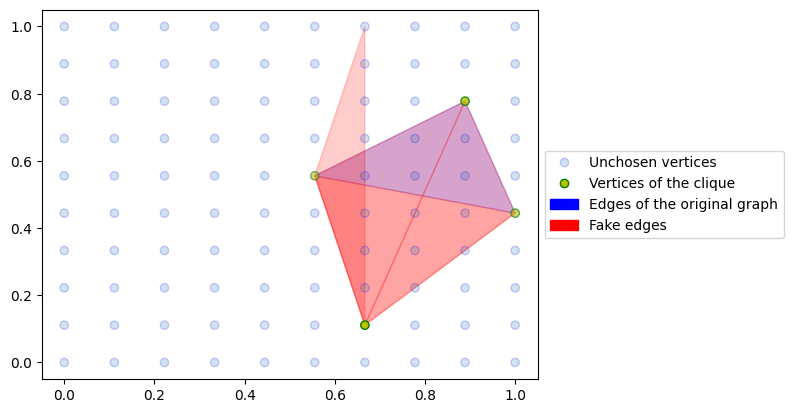


 FDFW found a 4-defective clique of size 4.


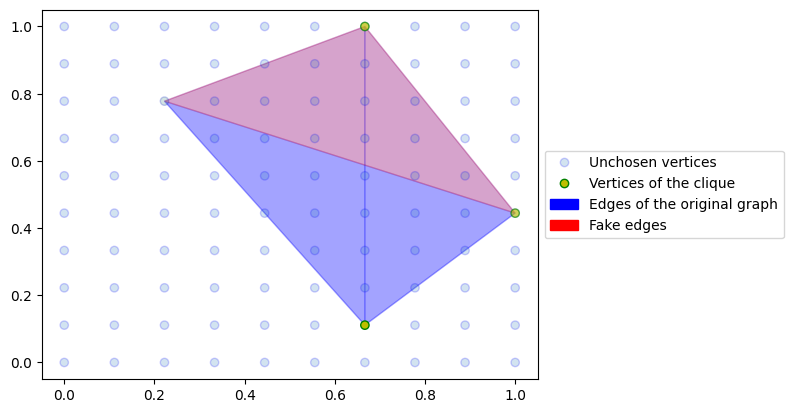


 FDFW on x found a 4-defective clique of size 4.


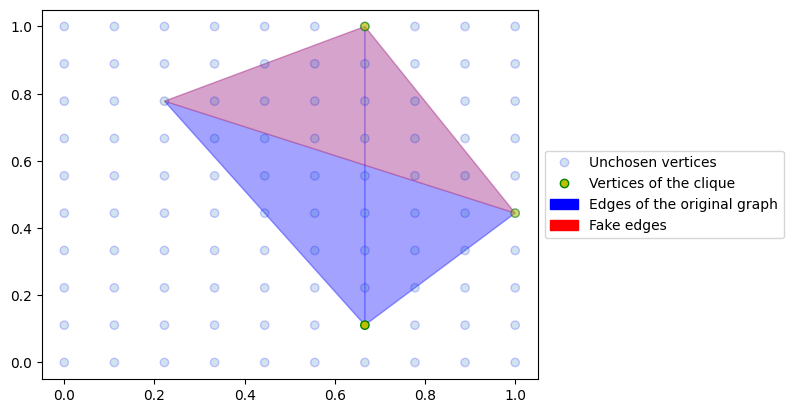

In [ ]:
# Parameters
k = 3  # Number of vertices in an edge
s = 4  # Maximum number of missing edges in the clique
nd = 10  # Number of different values for x and y in the random hypergraph
prob = 0.1  # Probability of an edge existing in the random hypergraph
verbose = 1  # 0 for no verbosity, 1 for a message at the end of the run, 2 for each iteration, and 3 for a graph at each iteration

L0 = 1  # Initial value for the approximation of the Lipschitz constant in the SSC
stop_updating_y_after = None  # Skips the update of y after a certain number of iterations with no changes, set to None to perform all updates
max_iter = 20000  # Max number of iterations for each algorithm
tol = np.inf  # Tolerance for convergence, if np.inf then the algorithm stops as soon as an s-defective clique is identified

# Others parameters, leave untouched
k_factorial = np.math.factorial(k)  # Preprocessing
n = nd**2
alpha = 0.2 if k == 2 else 1 / (k * (k - 1))
beta = n**(-k) / 2

x = np.linspace(0, 1, nd)
y = np.linspace(0, 1, nd)
xx, yy = np.meshgrid(x, y)

vertices = np.vstack((xx.ravel(), yy.ravel()))

# Generate a random hypergraph
A = generate_random_adjacency_tensor(k, n, prob)
Abar = complementary_hypergraph(A)

# Define objective functions and gradients
objective = lambda x, y: objective_function(Abar, x, y, k, k_factorial, alpha, beta)
gradient_fx = lambda x, y: objective_function_gradient_x(Abar, x, y, k, k_factorial, alpha)
reduced_gradient_fy = lambda x, y: objective_function_reduced_gradient_y(Abar, x, y, k_factorial, beta)

objective_no_y = lambda x: objective_function(Abar, x, np.zeros(A.shape), k, k_factorial, alpha, beta)
gradient_fx_no_y = lambda x: objective_function_gradient_x(Abar, x, np.zeros(A.shape), k, k_factorial, alpha)

# Initialize x0 randomly on the simplex
x0 = np.random.dirichlet(np.ones(n))

# Initialize y0 as a symmetric tensor
y0 = np.zeros(A.shape)

# Run the optimization, uncomment the algorithm you want to test
x_opt1, y_opt1, runtime = FWdc_SSC(objective, gradient_fx, reduced_gradient_fy, A, Abar, x0, y0, L0, n, s, k_factorial, stop_updating_y_after, max_iter, tol, verbosity=verbose, vertex_positions=vertices)
x_opt2, y_opt2, runtime = FDFW_SSC(objective, gradient_fx, reduced_gradient_fy, A, Abar, x0, y0, L0, n, s, k_factorial, max_iter, tol, verbosity=verbose, vertex_positions=vertices)
x_opt3, runtime = FDFW_only_x_SSC(objective_no_y, gradient_fx_no_y, A, x0, L0, n, s, k_factorial, max_iter, tol, verbosity=verbose, vertex_positions=vertices)

# Print the final sizes of the s-defective cliques and plot it
# FWdc
print(f"\n FWdc found a {s}-defective clique of size {np.sum(x_opt1 > 0)}.")

if verbose != 3:
    plot_fake_edges_and_final_clique(A, vertices, x_opt1, y_opt1)

# FDFW
print(f"\n FDFW found a {s}-defective clique of size {np.sum(x_opt2 > 0)}.")

if verbose != 3:
    # Extracting y because y_e = 0 or 1 is not enforced (we stop before convergence)
    y_opt2_real = np.zeros(A.shape)

    for idx in list(combinations(np.where(x_opt2 > 0)[0], k)):
        y_opt2_real[idx] = 1

    y_opt2_real[A == 1] = 0

    # Plot
    plot_fake_edges_and_final_clique(A, vertices, x_opt2, y_opt2_real)

# FDFW on x
print(f"\n FDFW on x found a {s}-defective clique of size {np.sum(x_opt3 > 0)}.")

if verbose != 3:
    # Extracting y
    y_opt3 = np.zeros(A.shape)

    for idx in list(combinations(np.where(x_opt3 > 0)[0], k)):
        y_opt3[idx] = 1

    y_opt3[A == 1] = 0

    # Plot
    plot_fake_edges_and_final_clique(A, vertices, x_opt3, y_opt3)


# Comparison between the previous and the novel formulations

This section compares the solution quality of the two formulations (for $k=2$), optimized with the FDFW and the FWdc algorithms.

In [ ]:
# Parameters
graph_names = [
    "C125.9", "C250.9", "brock200_2", "brock200_4", "keller4", "p_hat300-1", "p_hat300-2", "p_hat300-3"
]  # List of graph names on which the two formulations will be tested

s = 4  # Maximum number of missing edges in the clique

L0 = 1  # Initial value for the approximation of the Lipschitz constant in the SSC
max_number_sampling = 100  # Maximum number of restarts for each algorithm on each graph
max_time_allowed_in_seconds = 3000  # Maximum time allowed for the restarts, finishes the last execution and stops further restarts
stop_updating_y_after = None  # Skips the update of y after a certain number of iterations with no changes, set to None to perform all updates
max_iter = np.inf  # Max number of iterations for each algorithm
tol = np.inf  # Tolerance for convergence, if np.inf then the algorithm stops as soon as an s-defective clique is identified

# Preprocessing
k = 2
k_factorial = np.math.factorial(k)

In [ ]:
# Call the function to download and convert the graphs
graph_data = download_and_convert_DIMACS_graphs(graph_names, k)

# Initialize data storage
support_sizes_FWdc_old = {}
runtimes_FWdc_old = {}

support_sizes_FWdc_new = {}
runtimes_FWdc_new = {}

support_sizes_FDFW_old = {}
runtimes_FDFW_old = {}

support_sizes_FDFW_new = {}
runtimes_FDFW_new = {}

# Access the k-graph tensor for each graph
for graph_name, k_graph_tensor in graph_data.items():
    # Initialize the time counters
    time_counter_FWdc_old = 0
    time_counter_FWdc_new = 0
    time_counter_FDFW_old = 0
    time_counter_FDFW_new = 0

    # Initialize dictionaries to store results for each graph
    support_sizes_FWdc_old[graph_name] = []
    runtimes_FWdc_old[graph_name] = []

    support_sizes_FWdc_new[graph_name] = []
    runtimes_FWdc_new[graph_name] = []

    support_sizes_FDFW_old[graph_name] = []
    runtimes_FDFW_old[graph_name] = []

    support_sizes_FDFW_new[graph_name] = []
    runtimes_FDFW_new[graph_name] = []

    print(f"Currently doing graph: {graph_name}")

    # Extract graph information
    A = k_graph_tensor
    Abar = complementary_hypergraph(A)
    n = A.shape[0]

    # Define regularization parameters
    # Old formulation
    alpha_old = 1
    beta_old = 2 / n**2

    # New formulation
    alpha_new = 0.45
    beta_new = n**(-2) / 2

    # Define objective functions and gradients
    objective_old = lambda x, y: old_objective_function(A, x, y, alpha_old, beta_old)
    gradient_fx_old = lambda x, y: old_objective_function_gradient_x(A, x, y, alpha_old)
    reduced_gradient_fy_old = lambda x, y: old_objective_function_reduced_gradient_y(Abar, x, y, beta_old)

    objective_new = lambda x, y: objective_function(Abar, x, y, k, k_factorial, alpha_new, beta_new)
    gradient_fx_new = lambda x, y: objective_function_gradient_x(Abar, x, y, k, k_factorial, alpha_new)
    reduced_gradient_fy_new = lambda x, y: objective_function_reduced_gradient_y(Abar, x, y, k_factorial, beta_new)

    for i in range(max_number_sampling):
        # Initialize x0 randomly on the simplex
        x0 = np.random.dirichlet(np.ones(n))

        # Initialize y0 as a symmetric tensor
        y0 = np.zeros(A.shape)

        # Run the FWdc optimization with the old formulation
        # Stop the restarts if the maximum allowed time has been hit
        if time_counter_FWdc_old < max_time_allowed_in_seconds:
            x_opt, y_opt, runtime = FWdc_SSC(objective_old, gradient_fx_old, reduced_gradient_fy_old, A, Abar, x0, y0, L0, n, s, k_factorial, stop_updating_y_after, max_iter, tol, verbosity=0)
            time_counter_FWdc_old += runtime

            if is_s_defective_clique(A, x_opt, s):
                # Calculate the size of the support of x
                support_size = np.sum(x_opt > 0)

                # Store the results
                support_sizes_FWdc_old[graph_name].append(support_size)
                runtimes_FWdc_old[graph_name].append(runtime)
            else:
                print("FWdc did not converge.")

        # Run the FWdc optimization with the new formulation
        # Stop the restarts if the maximum allowed time has been hit
        if time_counter_FWdc_new < max_time_allowed_in_seconds:
            x_opt, y_opt, runtime = FWdc_SSC(objective_new, gradient_fx_new, reduced_gradient_fy_new, A, Abar, x0, y0, L0, n, s, k_factorial, stop_updating_y_after, max_iter, tol, verbosity=0)
            time_counter_FWdc_new += runtime

            if is_s_defective_clique(A, x_opt, s):
                # Calculate the size of the support of x
                support_size = np.sum(x_opt > 0)

                # Store the results
                support_sizes_FWdc_new[graph_name].append(support_size)
                runtimes_FWdc_new[graph_name].append(runtime)
            else:
                print("FWdc did not converge.")

        # Run the FDFW optimization with the old formulation
        # Stop the restarts if the maximum allowed time has been hit
        if time_counter_FDFW_old < max_time_allowed_in_seconds:
            x_opt, y_opt, runtime = FDFW_SSC(objective_old, gradient_fx_old, reduced_gradient_fy_old, A, Abar, x0, y0, L0, n, s, k_factorial, max_iter, tol, verbosity=0)
            time_counter_FDFW_old += runtime

            if is_s_defective_clique(A, x_opt, s):
                # Calculate the size of the support of x
                support_size = np.sum(x_opt > 0)

                # Store the results
                support_sizes_FDFW_old[graph_name].append(support_size)
                runtimes_FDFW_old[graph_name].append(runtime)
            else:
                print("FDFW did not converge.")

        # Run the FDFW optimization with the new formulation
        # Stop the restarts if the maximum allowed time has been hit
        if time_counter_FDFW_new < max_time_allowed_in_seconds:
            x_opt, y_opt, runtime = FDFW_SSC(objective_new, gradient_fx_new, reduced_gradient_fy_new, A, Abar, x0, y0, L0, n, s, k_factorial, max_iter, tol, verbosity=0)
            time_counter_FDFW_new += runtime

            if is_s_defective_clique(A, x_opt, s):
                # Calculate the size of the support of x
                support_size = np.sum(x_opt > 0)

                # Store the results
                support_sizes_FDFW_new[graph_name].append(support_size)
                runtimes_FDFW_new[graph_name].append(runtime)
            else:
                print("FDFW did not converge.")

# Create a new dictionary for the normalized clique sizes
normalized_support_sizes_FWdc_old = {}
normalized_support_sizes_FWdc_new = {}
normalized_support_sizes_FDFW_old = {}
normalized_support_sizes_FDFW_new = {}

# Iterate through the original dictionary
for key, values in support_sizes_FWdc_old.items():
    normalized_support_sizes_FWdc_old[key] = [value/best_known_cliques_sizes[key] for value in support_sizes_FWdc_old[key]]
    normalized_support_sizes_FWdc_new[key] = [value/best_known_cliques_sizes[key] for value in support_sizes_FWdc_new[key]]
    normalized_support_sizes_FDFW_old[key] = [value/best_known_cliques_sizes[key] for value in support_sizes_FDFW_old[key]]
    normalized_support_sizes_FDFW_new[key] = [value/best_known_cliques_sizes[key] for value in support_sizes_FDFW_new[key]]

In [ ]:
# Plot the normalized sizes of the cliques found for each graph
box_and_whisker_plot(
    (normalized_support_sizes_FWdc_old, normalized_support_sizes_FWdc_new, normalized_support_sizes_FDFW_old, normalized_support_sizes_FDFW_new),
    ["Graph", "Ratio (Found s-defective clique size) \n / (Best known clique size)"],
    ["FWdc (old formulation)", "FWdc (new formulation)", "FDFW on x (old formulation)", "FDFW on x (new formulation)"],
    title="Normalized sizes of the s-defective \n cliques found for each graph (k = %i, s = %i)" % (k, s)
)

# Plot the runtimes for each graph (log scale)
box_and_whisker_plot(
    (runtimes_FWdc_old, runtimes_FWdc_new, runtimes_FDFW_old, runtimes_FDFW_new),
    ["Graph", "Runtime (in seconds)"],
    ["FWdc (old formulation)", "FWdc (new formulation)", "FDFW on x (old formulation)", "FDFW on x (new formulation)"],
    y_scale='log',
    title="Runtimes for each graph (k = %i, s = %i)" % (k, s)
)

# Application to the DIMACS dataset (varying graph)

This section compares the solution quality and the runtime between the FWdc, the full FDFW and a simple FDFW on x stopping as soon as the support of x is an $s$-defective clique. The following part compares the performances on each graph, with a single value for s.

In [ ]:
# Parameters
k = 3  # Number of vertices in an edge

# Parameters
graph_names = [
    "C125.9", "C250.9", "brock200_2", "brock200_4",
    "keller4", "p_hat300-1", "p_hat300-2", "p_hat300-3"
]  # List of graph names on which the two formulations will be tested

s = 4  # Maximum number of missing edges in the clique

L0 = 1  # Initial value for the approximation of the Lipschitz constant in the SSC
max_number_sampling = 100  # Maximum number of restarts for each algorithm on each graph
max_time_allowed_in_seconds = 3000  # Maximum time allowed for the restarts, finishes the last execution and stops further restarts
stop_updating_y_after = None  # Skips the update of y after a certain number of iterations with no changes, set to None to perform all updates
max_iter = np.inf  # Max number of iterations for each algorithm
tol = np.inf  # Tolerance for convergence, if np.inf then the algorithm stops as soon as an s-defective clique is identified

# Preprocessing
k_factorial = np.math.factorial(k)


In [ ]:
# Call the function to download and convert the graphs
graph_data = download_and_convert_DIMACS_graphs(graph_names, k)

# Initialize data storage
support_sizes_FWdc = {}
runtimes_FWdc = {}

support_sizes_FDFW = {}
runtimes_FDFW = {}

support_sizes_FDFW_on_x = {}
runtimes_FDFW_on_x = {}

# Access the k-graph tensor for each graph
for graph_name, k_graph_tensor in graph_data.items():
    # Initialize the time counters
    time_counter_FWdc = 0
    time_counter_FDFW = 0
    time_counter_FDFW_on_x = 0

    # Initialize dictionaries to store results for each graph
    support_sizes_FWdc[graph_name] = []
    runtimes_FWdc[graph_name] = []

    support_sizes_FDFW[graph_name] = []
    runtimes_FDFW[graph_name] = []

    support_sizes_FDFW_on_x[graph_name] = []
    runtimes_FDFW_on_x[graph_name] = []

    print(f"Currently doing graph: {graph_name}")

    # Extract graph information
    A = k_graph_tensor
    Abar = complementary_hypergraph(A)
    n = A.shape[0]

    # Define regularization parameters
    alpha = 0.45 if k == 2 else 1 / (k * (k - 1))
    beta = n**(-k) / 2

    # Define objective functions and gradients
    objective = lambda x, y: objective_function(Abar, x, y, k, k_factorial, alpha, beta)
    gradient_fx = lambda x, y: objective_function_gradient_x(Abar, x, y, k, k_factorial, alpha)
    reduced_gradient_fy = lambda x, y: objective_function_reduced_gradient_y(Abar, x, y, k_factorial, beta)

    objective_no_y = lambda x: objective_function(Abar, x, np.zeros(A.shape), k, k_factorial, alpha, beta)
    gradient_fx_no_y = lambda x: objective_function_gradient_x(Abar, x, np.zeros(A.shape), k, k_factorial, alpha)

    for i in range(max_number_sampling):
        # Initialize x0 randomly on the simplex
        x0 = np.random.dirichlet(np.ones(n))

        # Initialize y0 as a symmetric tensor
        y0 = np.zeros(A.shape)

        # Run the FWdc optimization
        # Stop the restarts if the maximum allowed time has been hit
        if time_counter_FWdc < max_time_allowed_in_seconds:
            x_opt, y_opt, runtime = FWdc_SSC(objective, gradient_fx, reduced_gradient_fy, A, Abar, x0, y0, L0, n, s, k_factorial, stop_updating_y_after, max_iter, tol, verbosity=0)
            time_counter_FWdc += runtime

            if is_s_defective_clique(A, x_opt, s):
                # Calculate the size of the support of x
                support_size = np.sum(x_opt > 0)

                # Store the results
                support_sizes_FWdc[graph_name].append(support_size)
                runtimes_FWdc[graph_name].append(runtime)
            else:
                print("FWdc did not converge.")

        # Run the FDFW optimization
        # Stop the restarts if the maximum allowed time has been hit
        if time_counter_FDFW < max_time_allowed_in_seconds:
            x_opt, y_opt, runtime = FDFW_SSC(objective, gradient_fx, reduced_gradient_fy, A, Abar, x0, y0, L0, n, s, k_factorial, max_iter, tol, verbosity=0)
            time_counter_FDFW += runtime

            if is_s_defective_clique(A, x_opt, s):
                # Calculate the size of the support of x
                support_size = np.sum(x_opt > 0)

                # Store the results
                support_sizes_FDFW[graph_name].append(support_size)
                runtimes_FDFW[graph_name].append(runtime)
            else:
                print("FDFW did not converge.")

        # Run the FDFW on x optimization
        # Stop the restarts if the maximum allowed time has been hit
        if time_counter_FDFW_on_x < max_time_allowed_in_seconds:
            x_opt, runtime = FDFW_only_x_SSC(objective_no_y, gradient_fx_no_y, A, x0, L0, n, s, k_factorial, max_iter, tol, verbosity=0)
            time_counter_FDFW_on_x += runtime

            if is_s_defective_clique(A, x_opt, s):
                # Calculate the size of the support of x
                support_size = np.sum(x_opt > 0)

                # Store the results
                support_sizes_FDFW_on_x[graph_name].append(support_size)
                runtimes_FDFW_on_x[graph_name].append(runtime)
            else:
                print("FDFW on x did not converge.")

# Create a new dictionary for the normalized clique sizes
normalized_support_sizes_FWdc = {}
normalized_support_sizes_FDFW = {}
normalized_support_sizes_FDFW_on_x = {}

# Iterate through the original dictionary
for key, values in support_sizes_FWdc.items():
    normalized_support_sizes_FWdc[key] = [value/best_known_cliques_sizes[key] for value in support_sizes_FWdc[key]]
    normalized_support_sizes_FDFW[key] = [value/best_known_cliques_sizes[key] for value in support_sizes_FDFW[key]]
    normalized_support_sizes_FDFW_on_x[key] = [value/best_known_cliques_sizes[key] for value in support_sizes_FDFW_on_x[key]]

In [ ]:
# Plot the normalized sizes of the cliques found for each graph
box_and_whisker_plot(
    (normalized_support_sizes_FWdc, normalized_support_sizes_FDFW, normalized_support_sizes_FDFW_on_x),
    ["Graph", "Ratio (Found s-defective clique size) \n / (Best known clique size)"],
    ["FWdc ", "FDFW", "FDFW on x"],
    title="Normalized sizes of the s-defective \n cliques found for each graph (k = %i, s = %i)" % (k, s)
)

# Plot the runtimes for each graph (log scale)
box_and_whisker_plot(
    (runtimes_FWdc, runtimes_FDFW, runtimes_FDFW_on_x),
    ["Graph", "Runtime (in seconds)"],
    ["FWdc ", "FDFW", "FDFW on x"],
    y_scale='log',
    title="Runtimes for each graph (k = %i, s = %i)" % (k, s)
)

# Application to the DIMACS dataset (varying $s$)

The following part compares the FWdc, the full FDFW and the FDFW on x with varying values for s. For each graph, only the best found s-defective clique size is kept.

In [36]:
# Parameters
k = 3  # Number of vertices in an edge

# Parameters
graph_names = [
    "C125.9", "C250.9", "brock200_2", "brock200_4",
    "keller4", "p_hat300-1", "p_hat300-2", "p_hat300-3"
]  # List of graph names on which the two formulations will be tested

s_values = np.arange(1, 5)  # List of values of s on which the two algorithms will be tested

L0 = 1  # Initial value for the approximation of the Lipschitz constant in the SSC
max_number_sampling = 100  # Maximum number of restarts for each algorithm on each graph
max_time_allowed_in_seconds = 300  # Maximum time allowed for the restarts, finishes the last execution and stops further restarts
stop_updating_y_after = None  # Skips the update of y after a certain number of iterations with no changes, set to None to perform all updates
max_iter = 10000  # Max number of iterations for each algorithm
tol = np.inf  # Tolerance for convergence, if np.inf then the algorithm stops as soon as an s-defective clique is identified

# Preprocessing
k_factorial = np.math.factorial(k)

In [ ]:
# Call the function to download and convert the graphs
graph_data = download_and_convert_DIMACS_graphs(graph_names, k)

# Initialize data storage
support_sizes_FWdc = {}
runtimes_FWdc = {}

support_sizes_FDFW = {}
runtimes_FDFW = {}

support_sizes_FDFW_on_x = {}
runtimes_FDFW_on_x = {}

# Run random initializations on each graph for each value of s
for s_value in s_values:
    print(f"Currently doing s = {s_value}")

    # Initialize dictionaries to store results for each graph
    support_sizes_FWdc[s_value] = {}
    support_sizes_FDFW[s_value] = {}
    support_sizes_FDFW_on_x[s_value] = {}

    runtimes_FWdc[str(s_value)] = []
    runtimes_FDFW[str(s_value)] = []
    runtimes_FDFW_on_x[str(s_value)] = []

    # Access the k-graph tensor for each graph
    for graph_name, k_graph_tensor in graph_data.items():
        # Initialize the time counters
        time_counter_FWdc = 0
        time_counter_FDFW = 0
        time_counter_FDFW_on_x = 0

        # Initialize the time counter
        start_time = time.time()

        # Initialize values and dictionaries to store results for each graph
        support_sizes_FWdc[s_value][graph_name] = []
        support_sizes_FDFW[s_value][graph_name] = []
        support_sizes_FDFW_on_x[s_value][graph_name] = []

        # Extract graph information
        A = k_graph_tensor
        Abar = complementary_hypergraph(A)
        n = A.shape[0]

        # Define regularization parameters
        alpha = 0.45 if k == 2 else 1 / (k * (k - 1))
        beta = n**(-k) / 2

        # Define objective functions and gradients
        objective = lambda x, y: objective_function(Abar, x, y, k, k_factorial, alpha, beta)
        gradient_fx = lambda x, y: objective_function_gradient_x(Abar, x, y, k, k_factorial, alpha)
        reduced_gradient_fy = lambda x, y: objective_function_reduced_gradient_y(Abar, x, y, k_factorial, beta)

        objective_no_y = lambda x: objective_function(Abar, x, np.zeros(A.shape), k, k_factorial, alpha, beta)
        gradient_fx_no_y = lambda x: objective_function_gradient_x(Abar, x, np.zeros(A.shape), k, k_factorial, alpha)

        for i in range(max_number_sampling):
            # Initialize x0 randomly on the simplex
            x0 = np.random.dirichlet(np.ones(n))

            # Initialize y0 as a symmetric tensor
            y0 = np.zeros(A.shape)

            # Run the FWdc optimization
            # Stop the restarts if the maximum allowed time has been hit
            if time_counter_FWdc < max_time_allowed_in_seconds:
                x_opt, y_opt, runtime = FWdc_SSC(objective, gradient_fx, reduced_gradient_fy, A, Abar, x0, y0, L0, n, s_value, k_factorial, stop_updating_y_after, max_iter, tol, verbosity=0)
                time_counter_FWdc += runtime

                if is_s_defective_clique(A, x_opt, s_value):
                    # Calculate the size of the support of x
                    support_size = np.sum(x_opt > 0)

                    # Store the results
                    support_sizes_FWdc[s_value][graph_name].append(support_size)
                    runtimes_FWdc[str(s_value)].append(runtime)
                else:
                    print("FWdc did not converge.")

            # Run the FDFW optimization
            # Stop the restarts if the maximum allowed time has been hit
            if time_counter_FDFW < max_time_allowed_in_seconds:
                x_opt, y_opt, runtime = FDFW_SSC(objective, gradient_fx, reduced_gradient_fy, A, Abar, x0, y0, L0, n, s_value, k_factorial, max_iter, tol, verbosity=0)
                time_counter_FDFW += runtime

                if is_s_defective_clique(A, x_opt, s_value):
                    # Calculate the size of the support of x
                    support_size = np.sum(x_opt > 0)

                    # Store the results
                    support_sizes_FDFW[s_value][graph_name].append(support_size)
                    runtimes_FDFW[str(s_value)].append(runtime)
                else:
                    print("FDFW did not converge.")

            # Run the FDFW on x optimization
            # Stop the restarts if the maximum allowed time has been hit
            if time_counter_FDFW_on_x < max_time_allowed_in_seconds:
                x_opt, runtime = FDFW_only_x_SSC(objective_no_y, gradient_fx_no_y, A, x0, L0, n, s_value, k_factorial, max_iter, tol, verbosity=0)
                time_counter_FDFW_on_x += runtime

                if is_s_defective_clique(A, x_opt, s_value):
                    # Calculate the size of the support of x
                    support_size = np.sum(x_opt > 0)

                    # Store the results
                    support_sizes_FDFW_on_x[s_value][graph_name].append(support_size)
                    runtimes_FDFW_on_x[str(s_value)].append(runtime)
                else:
                    print("FDFW on x did not converge.")

# Store the maximum clique sizes found
normalized_support_sizes_FWdc = {
    str(s_value): [np.max(support_sizes_FWdc[s_value][graph_name]) / best_known_cliques_sizes[graph_name] for graph_name in graph_names] for s_value in s_values
}
normalized_support_sizes_FDFW = {
    str(s_value): [np.max(support_sizes_FDFW[s_value][graph_name]) / best_known_cliques_sizes[graph_name] for graph_name in graph_names] for s_value in s_values
}
normalized_support_sizes_FDFW_on_x = {
    str(s_value): [np.max(support_sizes_FDFW_on_x[s_value][graph_name]) / best_known_cliques_sizes[graph_name] for graph_name in graph_names] for s_value in s_values
}

In [ ]:
# Plot the normalized sizes of the cliques found for each value of s
box_and_whisker_plot(
    (normalized_support_sizes_FWdc, normalized_support_sizes_FDFW_on_x),
    ["s", "Ratio (Best found s-defective clique size) \n / (Best known clique size)"],
    ["FWdc", "FDFW on x"],
    title="Normalized sizes of the s-defective \n cliques found for each value of s (k = %i)" % k
)


# Plot the runtimes for each graph (log scale)
box_and_whisker_plot(
     (runtimes_FWdc, runtimes_FDFW_on_x),
     ["Graph", "Runtime (in seconds)"],
     ["FWdc", "FDFW on x"],
     y_scale='log',
     title="Runtimes for each graph (k = %i)" % k
)